<a href="https://colab.research.google.com/github/Ravi-ranjan1801/CUDA-Lab/blob/main/cuda_lab_04_thread_variation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
%%writefile thread_variation_fixed.cu
// thread_variation_fixed.cu
#include <stdio.h>
#include <cuda.h>
#include <stdlib.h>

#define N 1000000

__global__ void add(int *A,int *B,int *C,int n){
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if(i < n)
        C[i] = A[i] + B[i];
}

int main(){

    int threads_list[] = {3,5,7,32,64,128,256};
    int num_tests = 7;

    int *hA=(int*)malloc(N*sizeof(int));
    int *hB=(int*)malloc(N*sizeof(int));
    int *hC=(int*)malloc(N*sizeof(int));

    for(int i=0;i<N;i++){
        hA[i]=i;
        hB[i]=i;
    }

    int *dA,*dB,*dC;
    cudaMalloc(&dA,N*sizeof(int));
    cudaMalloc(&dB,N*sizeof(int));
    cudaMalloc(&dC,N*sizeof(int));

    cudaMemcpy(dA,hA,N*sizeof(int),cudaMemcpyHostToDevice);
    cudaMemcpy(dB,hB,N*sizeof(int),cudaMemcpyHostToDevice);

    FILE *f=fopen("thread_times.csv","w");
    fprintf(f,"Threads,GPU_Time\n");

    for(int t=0; t<num_tests; t++){

        int threads = threads_list[t];
        int blocks = (N + threads - 1) / threads;

        cudaEvent_t s,e;
        cudaEventCreate(&s);
        cudaEventCreate(&e);

        cudaEventRecord(s);
        add<<<blocks,threads>>>(dA,dB,dC,N);
        cudaEventRecord(e);
        cudaEventSynchronize(e);

        float ms;
        cudaEventElapsedTime(&ms,s,e);

        printf("Threads=%d  Time=%f ms\n",threads,ms);
        fprintf(f,"%d,%f\n",threads,ms);

        cudaEventDestroy(s);
        cudaEventDestroy(e);
    }

    fclose(f);

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);
    free(hA);
    free(hB);
    free(hC);

    printf("\nCSV file created successfully.\n");
    return 0;
}


Overwriting thread_variation_fixed.cu


In [41]:
!nvcc thread_variation_fixed.cu -o thread_test
!./thread_test

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
Threads=3  Time=1.043872 ms
Threads=5  Time=0.542944 ms
Threads=7  Time=0.385568 ms
Threads=32  Time=0.102400 ms
Threads=64  Time=0.053248 ms
Threads=128  Time=0.053216 ms
Threads=256  Time=0.053984 ms

CSV file created successfully.


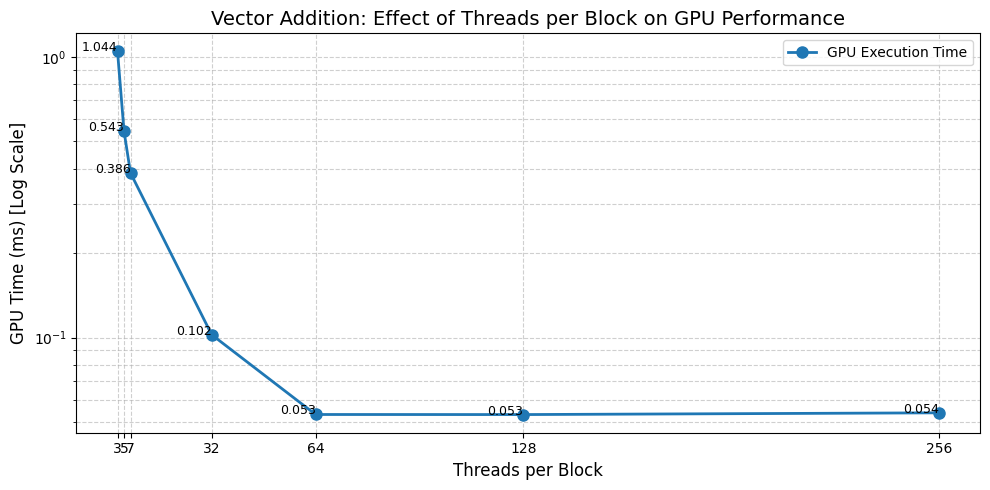

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

d = pd.read_csv("thread_times.csv")

plt.figure(figsize=(10,5))

plt.plot(d.Threads, d.GPU_Time,
         marker='o',
         linewidth=2,
         markersize=8,
         label="GPU Execution Time")

# Log scale for better visibility
plt.yscale("log")

plt.xlabel("Threads per Block", fontsize=12)
plt.ylabel("GPU Time (ms) [Log Scale]", fontsize=12)
plt.title("Vector Addition: Effect of Threads per Block on GPU Performance",
          fontsize=14)

plt.xticks(d.Threads)
plt.grid(True, which="both", linestyle="--", alpha=0.6)

# Annotate values
for i in range(len(d)):
    plt.text(d.Threads[i],
             d.GPU_Time[i],
             f"{d.GPU_Time[i]:.3f}",
             fontsize=9,
             ha='right')

plt.legend()
plt.tight_layout()
plt.show()


In [43]:
%%writefile matmul_thread_variation.cu
// matmul_thread_variation.cu
#include <stdio.h>
#include <cuda.h>
#include <stdlib.h>

#define N 256   // matrix size (NxN)

__global__ void matMul(int *A, int *B, int *C, int n){
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if(row < n && col < n){
        int sum = 0;
        for(int k = 0; k < n; k++)
            sum += A[row*n + k] * B[k*n + col];

        C[row*n + col] = sum;
    }
}

int main(){

    int threads_list[] = {3,5,7,32,64,128,256};
    int tests = 7;

    int size = N * N * sizeof(int);

    int *hA = (int*)malloc(size);
    int *hB = (int*)malloc(size);
    int *hC = (int*)malloc(size);

    // Fill matrices
    for(int i=0;i<N*N;i++){
        hA[i] = 5;
        hB[i] = 7;
    }

    int *dA,*dB,*dC;
    cudaMalloc(&dA,size);
    cudaMalloc(&dB,size);
    cudaMalloc(&dC,size);

    cudaMemcpy(dA,hA,size,cudaMemcpyHostToDevice);
    cudaMemcpy(dB,hB,size,cudaMemcpyHostToDevice);

    FILE *f = fopen("matmul_thread_times.csv","w");
    fprintf(f,"Threads,GPU_Time\n");

    for(int t=0;t<tests;t++){

        int threads = threads_list[t];

        dim3 block(threads,1);
        dim3 grid((N + threads -1)/threads , N);

        cudaEvent_t s,e;
        cudaEventCreate(&s);
        cudaEventCreate(&e);

        cudaEventRecord(s);
        matMul<<<grid,block>>>(dA,dB,dC,N);
        cudaEventRecord(e);
        cudaEventSynchronize(e);

        float ms;
        cudaEventElapsedTime(&ms,s,e);

        printf("Threads=%d  Time=%f ms\n",threads,ms);
        fprintf(f,"%d,%f\n",threads,ms);

        cudaEventDestroy(s);
        cudaEventDestroy(e);
    }

    fclose(f);

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);
    free(hA);
    free(hB);
    free(hC);

    printf("\nCSV file created successfully.\n");
    return 0;
}


Overwriting matmul_thread_variation.cu


In [44]:
!nvcc matmul_thread_variation.cu -o matmul_test
!./matmul_test

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
Threads=3  Time=0.728352 ms
Threads=5  Time=0.359776 ms
Threads=7  Time=0.257856 ms
Threads=32  Time=0.067584 ms
Threads=64  Time=0.069632 ms
Threads=128  Time=0.067328 ms
Threads=256  Time=0.072224 ms

CSV file created successfully.


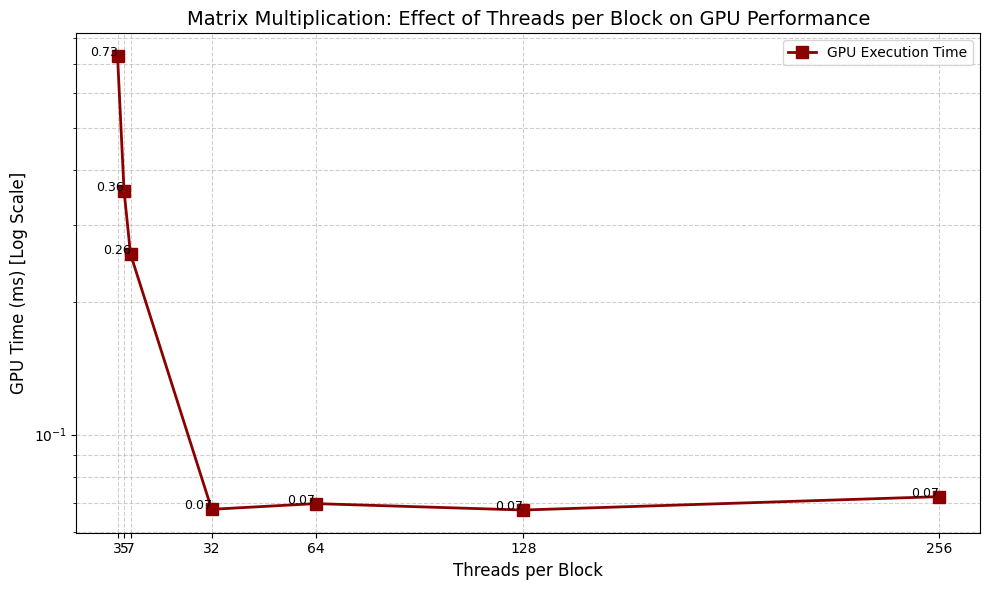

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

d = pd.read_csv("matmul_thread_times.csv")

plt.figure(figsize=(10,6))

plt.plot(d.Threads, d.GPU_Time,
         marker='s',
         linewidth=2,
         markersize=8,
         color='darkred',
         label="GPU Execution Time")

plt.yscale("log")

plt.xlabel("Threads per Block", fontsize=12)
plt.ylabel("GPU Time (ms) [Log Scale]", fontsize=12)
plt.title("Matrix Multiplication: Effect of Threads per Block on GPU Performance",
          fontsize=14)

plt.xticks(d.Threads)
plt.grid(True, which="both", linestyle="--", alpha=0.6)

for i in range(len(d)):
    plt.text(d.Threads[i],
             d.GPU_Time[i],
             f"{d.GPU_Time[i]:.2f}",
             fontsize=9,
             ha='right')

plt.legend()
plt.tight_layout()
plt.show()
